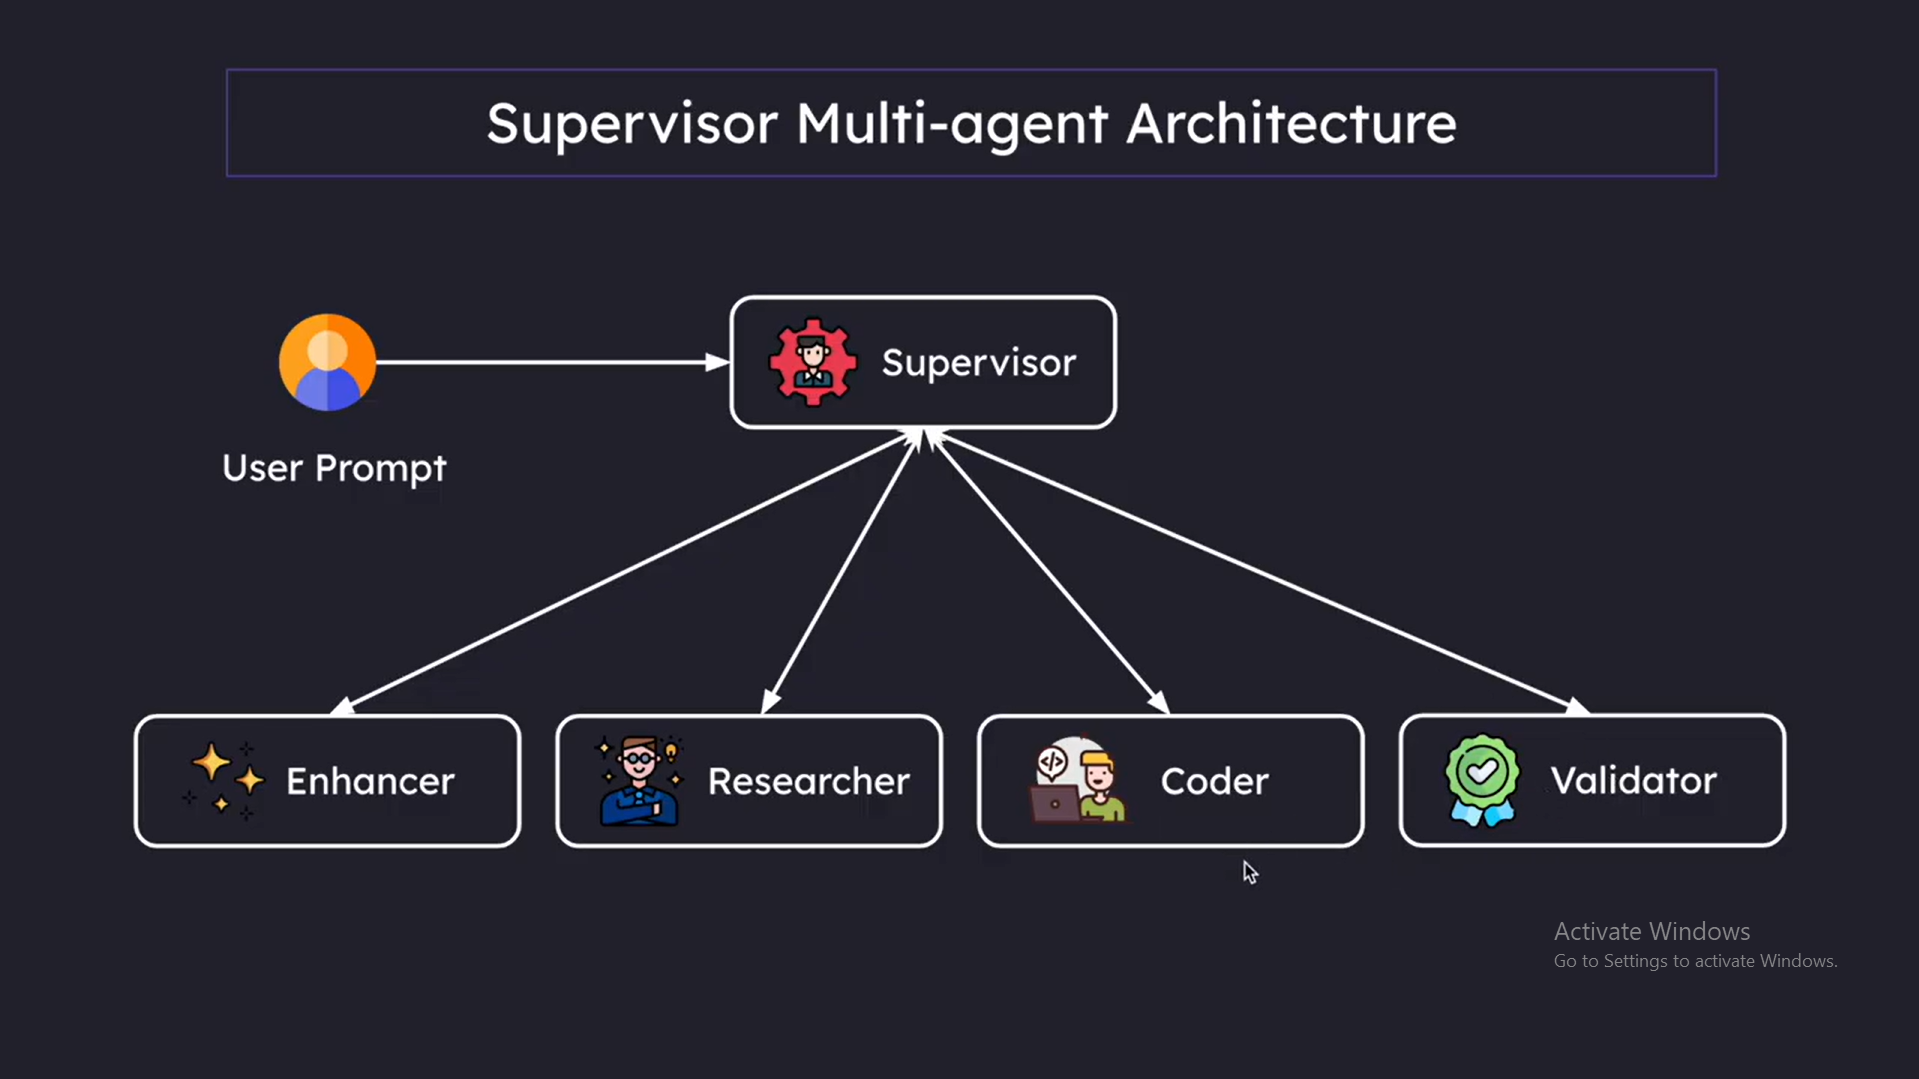

In [71]:
from typing import List, Annotated, Sequence, Literal
from langgraph.graph import StateGraph, END, START,MessagesState
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode
from langchain.messages import HumanMessage, AIMessage, SystemMessage
from pydantic import BaseModel, Field
from langchain_community.tools.tavily_search import TavilySearchResults 
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.types import Command
from langgraph.prebuilt import create_react_agent
from IPython.display import display, Markdown
from dotenv import load_dotenv
from langchain_experimental.tools import PythonREPLTool
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

load_dotenv(override=True)

True

## Implement LLM 
### + Tavily Search Tool 
### + Coder Agent
### + Python REPL Tool
### + Supervisor Agent

In [72]:
llm = ChatGoogleGenerativeAI(
    model="gemini-2.5-flash-lite",
    temperature=0.0,
    max_tokens=200,
)

## Tavily search tool
tavily_tool = TavilySearchResults(
    max_results=2,
)

## Python REPL tool
pythonTool =PythonREPLTool()

In [73]:
pythonTool.invoke("x=5;y=1000;print(x+y)")

'1005\n'

In [74]:
class Supervisor(BaseModel):
    next:Literal["enhancer","coder","researcher"]=Field(
           description="Determines which specialist to activate next in the workflow sequence: "
                    "'enhancer' when user input requires clarification, expansion, or refinement, "
                    "'researcher' when additional facts, context, or data collection is necessary, "
                    "'coder' when implementation, computation, or technical problem-solving is required."
            )
    reason:str = Field(
        description="Detailed justification for the routing decision, explaining the rationale behind selecting the particular specialist and how this advances the task toward completion."
    )

def supervisor_node(state:MessagesState)->Command[Literal["enhancer","coder","researcher"]]:
    system_prompt = ('''
                 
        You are a workflow supervisor managing a team of three specialized agents: Prompt Enhancer, Researcher, and Coder. Your role is to orchestrate the workflow by selecting the most appropriate next agent based on the current state and needs of the task. Provide a clear, concise rationale for each decision to ensure transparency in your decision-making process.

        **Team Members**:
        1. **Prompt Enhancer**: Always consider this agent first. They clarify ambiguous requests, improve poorly defined queries, and ensure the task is well-structured before deeper processing begins.
        2. **Researcher**: Specializes in information gathering, fact-finding, and collecting relevant data needed to address the user's request.
        3. **Coder**: Focuses on technical implementation, calculations, data analysis, algorithm development, and coding solutions.

        **Your Responsibilities**:
        1. Analyze each user request and agent response for completeness, accuracy, and relevance.
        2. Route the task to the most appropriate agent at each decision point.
        3. Maintain workflow momentum by avoiding redundant agent assignments.
        4. Continue the process until the user's request is fully and satisfactorily resolved.

        Your objective is to create an efficient workflow that leverages each agent's strengths while minimizing unnecessary steps, ultimately delivering complete and accurate solutions to user requests.
                 
    ''')

    messages =[
        {"role":"system","content":system_prompt},
    ] + state["messages"]

    response = llm.with_structured_output(Supervisor).invoke(messages)
    goto = response.next
    reason = response.reason

    print(f"--- Workflow Transition: Supervisor -> {goto.upper()} ---")
    print(f"Reason: {reason}")

    return Command(
    update={
        "messages":[
            HumanMessage(content=f"Supervisor Decision: {reason}")
        ]
    } ,
    goto=goto,
    )   

## Enhanced Agent

In [75]:
def enhancer_node(state:MessagesState) ->Command[Literal["supervisor"]]:
    """
        Enhancer agent node that improves and clarifies user queries.
        Takes the original user input and transforms it into a more precise,
        actionable request before passing it to the supervisor.
    """
   
    system_prompt = (
        "You are a Query Refinement Specialist with expertise in transforming vague requests into precise instructions. Your responsibilities include:\n\n"
        "1. Analyzing the original query to identify key intent and requirements\n"
        "2. Resolving any ambiguities without requesting additional user input\n"
        "3. Expanding underdeveloped aspects of the query with reasonable assumptions\n"
        "4. Restructuring the query for clarity and actionability\n"
        "5. Ensuring all technical terminology is properly defined in context\n\n"
        "Important: Never ask questions back to the user. Instead, make informed assumptions and create the most comprehensive version of their request possible."
    )
    messages = [
       { "role":"system", "content":system_prompt}, 
    ]+state["messages"]

    enhanced_query = llm.invoke(messages)
    
    print(f"--- Workflow Transition: Prompt Enhancer -> Supervisior ---")

    return Command(
        update={
            "messages": [
                HumanMessage(content=enhanced_query.content,
                name="enhancer"
                )
            ]
        },
        goto="supervisor"
    )



## Researcher Node

In [76]:
def researcher_node(state:MessagesState)->Command[Literal["validator"]]:
    """
        Research agent node that gathers information using Tavily search.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    research_agent = create_react_agent(
        llm,

        tools=[tavily_tool],
        prompt="""
        You are an Information Specialist with expertise in comprehensive research. Your responsibilities include:\n\n"
            "1. Identifying key information needs based on the query context\n"
            "2. Gathering relevant, accurate, and up-to-date information from reliable sources\n"
            "3. Organizing findings in a structured, easily digestible format\n"
            "4. Citing sources when possible to establish credibility\n"
            "5. Focusing exclusively on information gathering - avoid analysis or implementation\n\n"
            "Provide thorough, factual responses without speculation where information is unavailable."
        """
    )
    
    result = research_agent.invoke(state)

    print(f"--- Workflow Transition: Researcher -> Validator ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content,
                name="researcher"
                )
            ]
        },
        goto="validator"
    )

## Code Node

In [77]:
def code_node(state:MessagesState)->Command[Literal["validator"]]:
    """
        Code agent node that generates code based on the query context.
        Takes the current task state, performs relevant research,
        and returns findings for validation.
    """
    
    code_agent = create_react_agent(
        llm,
        tools=[python_repl],
        prompt=(
            "You are a coder and analyst. Focus on mathematical calculations, analyzing, solving math questions, "
            "and executing code. Handle technical problem-solving and data tasks."
        )
    )
    
    result = code_agent.invoke(state)

    print(f"--- Workflow Transition: Code -> Validator ---")
    
    return Command(
        update={
            "messages": [
                HumanMessage(content=result["messages"][-1].content,
                name="coder"
                )
            ]
        },
        goto="validator"
    )

In [78]:
# System prompt providing clear instructions to the validator agent
system_prompt = '''
    Your task is to ensure reasonable quality. 
    Specifically, you must:
    - Review the user's question (the first message in the workflow).
    - Review the answer (the last message in the workflow).
    - If the answer addresses the core intent of the question, even if not perfectly, signal to end the workflow with 'FINISH'.
    - Only route back to the supervisor if the answer is completely off-topic, harmful, or fundamentally misunderstands the question.
    
    - Accept answers that are "good enough" rather than perfect
    - Prioritize workflow completion over perfect responses
    - Give benefit of doubt to borderline answers
    
    Routing Guidelines:
    1. 'supervisor' Agent: ONLY for responses that are completely incorrect or off-topic.
    2. Respond with 'FINISH' in all other cases to end the workflow.
'''

class Validator(BaseModel):
    next:Literal["supervisor", "FINISH"]= Field(
        description= "Specifies the next worker in the pipeline: 'supervisor' to continue, 'FINISH' to terminate."
    )
    reason: str = Field(
        description= "The reason for the decision."
    )


def validator_node(state: dict) -> dict:
    messages = state["messages"]
    user_question = messages[0].content
    agent_answer = messages[-1].content
    
    validator_prompt = ChatPromptTemplate.from_messages([
        ("system", system_prompt),
        ("human", f"Question: {user_question}\nAnswer: {agent_answer}")
    ])
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": user_question},
        {"role": "assistant", "content": agent_answer},
    ]

    response = llm.with_structured_output(Validator).invoke(messages)

    goto = response.next
    reason = response.reason

    if goto=="FINISH" or goto==END:
        goto = END
        print(" --- Tranitioning to END ---")
    else:
        print(f"--- Workflow Transition: Validator -> Supervisor ---")

    
    return Command(
        update={
            "messages": [
             HumanMessage(content=reason,
             name="validator")   
            ]
        },
        goto=goto
    )

## Graph

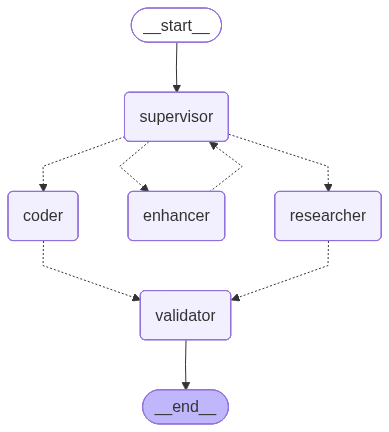

In [79]:
graph = StateGraph(MessagesState)

graph.add_node("supervisor", supervisor_node)
graph.add_node("researcher", researcher_node)
graph.add_node("validator", validator_node)
graph.add_node("enhancer",enhancer_node)
graph.add_node("coder",code_node)

graph.add_edge(START, "supervisor")

app= graph.compile()
app

In [80]:
import pprint

inputs = {
    "messages":[
        ("user","What is weather in Chennai?")
    ]
}

for event in app.stream(inputs):
    for key,value in event.items():
        if value is None:
            continue
        last_message = value.get("messages",[])[-1] if "messages" in value else None
        if last_message:
            pprint.pprint(f"Output from node '{key}'")
            pprint.pprint(last_message, indent=2, width=80,depth=None)
            print("\n")

--- Workflow Transition: Supervisor -> RESEARCHER ---
Reason: The user is asking a direct question that requires factual information. The Researcher agent is best suited to gather current weather data for Chennai.
"Output from node 'supervisor'"
HumanMessage(content='Supervisor Decision: The user is asking a direct question that requires factual information. The Researcher agent is best suited to gather current weather data for Chennai.', additional_kwargs={}, response_metadata={}, id='ae92e519-834a-419e-ab81-14b18a3a86bc')




G:\UnityTemp\ipykernel_14872\3948540953.py:8: LangGraphDeprecatedSinceV10: create_react_agent has been moved to `langchain.agents`. Please update your import to `from langchain.agents import create_agent`. Deprecated in LangGraph V1.0 to be removed in V2.0.
  research_agent = create_react_agent(


--- Workflow Transition: Researcher -> Validator ---
"Output from node 'researcher'"
HumanMessage(content='The weather in Chennai in February is generally pleasant. The average temperature is around 25.3°C (77.5°F), with maximum temperatures reaching up to 29.9°C (85.9°F) and minimum temperatures around 21°C (69.9°F). The water temperature is about 27°C (81°F). Rainfall is minimal, with an average of about 9mm for the month, and typically fewer than 2 rainy days.', additional_kwargs={}, response_metadata={}, name='researcher', id='bf584107-0340-4b6a-80e6-be3b0c47c602')


 --- Tranitioning to END ---
"Output from node 'validator'"
HumanMessage(content="The user asked for the weather in Chennai, and the model provided a detailed description of the weather conditions in Chennai for February, including temperature, rainfall, and water temperature. This directly answers the user's query.", additional_kwargs={}, response_metadata={}, name='validator', id='b57c176b-a052-463f-88f2-a077f7931b52